In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import seaborn as sns
import statsmodels.api as sm

## PART 1:

Load the following two datasets and answer the follow on questions:

In [2]:
crsp = pd.read_stata('https://github.com/LeDataSciFi/lectures-spr2020/blob/master/assignment_data/3firm_ret_1990_2020.dta?raw=true')
crsp['ret'] = crsp['ret']*100 # convert to precentage to match FF's convention on scaling
ff = pdr.get_data_famafrench('F-F_Research_Data_5_Factors_2x3_daily',start=1980,end=2010)[0] # the [0] is because the imported obect is a dictionary, and key=0 is the dataframe
ff = ff.reset_index().rename(columns={"Mkt-RF":"mkt_excess", "Date":"date"})
# ff.rename(columns={"Mkt-RF":"mkt_excess"}, inplace=True) # cleaner name


In [3]:
print(len(crsp))
print(len(ff))

30236
7571


### Questions

Assume that the stock data is the "left" dataset and the French data is the "right" dataset.

1. How many observations are there in `crsp` data?
1. How many observations are there in `ff` data?
1. How many observations are there after a left merge?
2. After a right merge? 
1. Why isn't the answer to Q2 and Q4 the same?
3. After an outer merge? 
4. After an inner merge?
5. Do a _**right**_ merge. Now, add a variable to this dataset that equals "the variance of the market return for the year" for each firm year (see the hint below on this). `describe()` the variable and output it.


In [4]:
quick_merge = lambda x: pd.merge(left=crsp,right=ff,on='date',how=x,indicator=True)
print(
f'''
Q1: N in L:                {len(crsp)}
Q2: N in R:                {len(ff)}
Q3: N after L merge:       {len(quick_merge("left"))}
Q4: N after R merge:       {len(quick_merge("right"))}
Q5: Q2 != Q4  b/c each day in R is joined to multiple obs in L.
Q6: N after Outer merge:   {len(quick_merge("outer"))}
Q7: N after Inner merge:   {len(quick_merge("inner"))}
'''
)


Q1: N in L:                30236
Q2: N in R:                7571
Q3: N after L merge:       30236
Q4: N after R merge:       22700
Q5: Q2 != Q4  b/c each day in R is joined to multiple obs in L.
Q6: N after Outer merge:   32764
Q7: N after Inner merge:   20172



## Q8: The main point of this question is the following rule

Annual volatility of daily market returns must be calculated from a dataset with 1 observation per day. If you try to calculate volatility after merging it to the CRSP data, every day will be repeated 3 times (once per firm) and this will alter your calculations. 

**So, the general rule: Create variables on the "lowest level" datasets possible, and then merge up.**

In [5]:
# Q8: merge CRSP into FF (a right merge), then add annual market excess returns
ff['year'] = ff['date'].dt.year

# the time series (1 value per year) annual variance is:
ff.groupby('year')['mkt_excess'].var().describe()

# this is NOT the answer Q8 is looking for... Q8 wants to describe after these values are merged into R and L.

count    30.000000
mean      1.203566
std       1.259848
min       0.232144
25%       0.495087
50%       0.757979
75%       1.182865
max       6.345088
Name: mkt_excess, dtype: float64

In [6]:
# route 1: save annual vol, then do the FF-CRSP merge, then merge in annual vol
ann_vol = ff.groupby('year')['mkt_excess'].var().reset_index()
ann_vol.columns = ['year','annual_var_correct']

right_merge = pd.merge(left=crsp,   right=ff,         on='date',how='right')   # merge FF-CRSP
right_merge = pd.merge(left=ann_vol,right=right_merge,on='year',how='right')   # add annual vol
right_merge['annual_var_correct'].describe()

count    22700.000000
mean         1.293303
std          1.347992
min          0.232144
25%          0.448911
50%          0.881702
75%          1.545627
max          6.345088
Name: annual_var_correct, dtype: float64

In [7]:
# route 2: same, just write the merges differently so no intermediate objects are named
(ff
     .merge(crsp,on='date',how='left')     # merge 1, in df1.merge(df2,...), df1 is "left" and "df2" is right
     .merge(ann_vol,on='year',how='left')  # merge 2
     ['annual_var_correct'].describe()     # output
)

count    22700.000000
mean         1.293303
std          1.347992
min          0.232144
25%          0.448911
50%          0.881702
75%          1.545627
max          6.345088
Name: annual_var_correct, dtype: float64

In [8]:
# route 3 WRONG: calculate it after the merge
temp = pd.merge(left = ff, right = crsp,on='date',how='left')
temp['annual_var_wrong'] = temp.groupby('year')['mkt_excess'].transform(lambda x: x.var())
temp['annual_var_wrong'].describe()

count    22700.000000
mean         1.289761
std          1.344051
min          0.231452
25%          0.447569
50%          0.879085
75%          1.541023
max          6.326260
Name: annual_var_wrong, dtype: float64

## One figure's improvement

### Before

Here is minimal code to reproduce it...

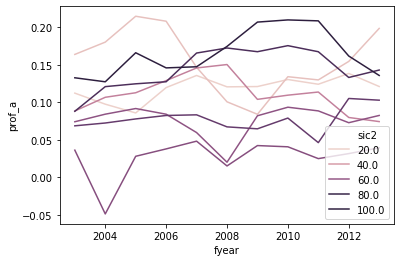

In [9]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

ccm = pd.read_stata('https://github.com/LeDataSciFi/lectures-spr2020/blob/master/assignment_data/CCM_cleaned_for_class.dta?raw=true')
ccm['sic3'] = pd.to_numeric(ccm['sic3'], errors='coerce')
sic2_year = (ccm
    .assign(sic2 = ccm['sic3']//10) 
    .query('fyear >= 2003 & fyear <= 2013 & sic2 != 99 & sic2 != 41')
    .groupby(['sic2','fyear'])
    [['td_a','prof_a']].mean()
)
lo4 = sic2_year.query('fyear == 2007')['td_a'].sort_values().reset_index()['sic2'][:4].to_list()
hi4 = sic2_year.query('fyear == 2007')['td_a'].sort_values().reset_index()['sic2'][-4:].to_list()
inds_to_examine = lo4.copy()
inds_to_examine.extend(hi4)
sns.lineplot(data = sic2_year.query('sic2 in @inds_to_examine').reset_index(),
             x = 'fyear', y='prof_a', hue='sic2')



### After

In [10]:
sic2_year_plot_sample = sic2_year.query('sic2 in @inds_to_examine').reset_index()
sic2_year_plot_sample['Group'] = 'High Lev Industries'
sic2_year_plot_sample.loc[ sic2_year_plot_sample['sic2'].isin(lo4), 'Group'] = 'Low Lev Industries'

In [11]:
# put industry labels in play
sic2_labels = pd.DataFrame({
    'sic2': [82.0, 31.0, 63.0, 47.0, 70.0, 27.0, 75.0, 61.0], 
    'sic2_ind': ['Educational Services','Leather Products','Insurance Carriers','Transportation Services',
                 'Hotels','Printing & Publishing','Auto Repairs','Nondepository Institutions']})
sic2_year_plot_sample = sic2_year_plot_sample.merge(sic2_labels,on='sic2')

Text(0.5, 1, 'Low Lev Industries')

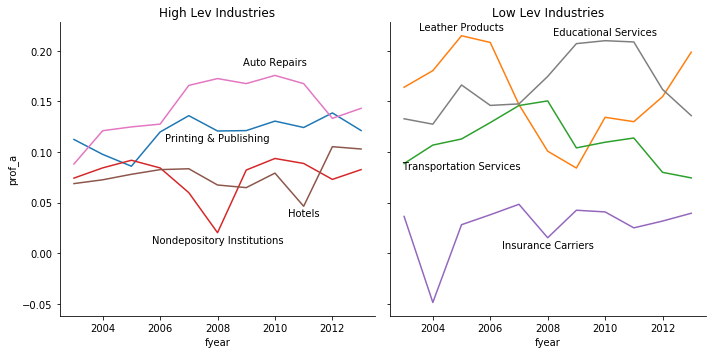

In [12]:
# plot the lines

ax = sns.relplot(data=sic2_year_plot_sample, x="fyear", y="prof_a",
            hue="sic2_ind", col="Group",kind='line',legend=False)

# now set up the labels to replace the legend - I'm going for "excellent"

ind_year_for_labels = '(fyear == 2008 & sic2 == 61) | (fyear == 2011 & sic2 == 70) | (fyear == 2010 & sic2 == 75) |' + \
                      '(fyear == 2008 & sic2 == 27) | (fyear == 2010 & sic2 == 82) | (fyear == 2005 & sic2 == 31) |' + \
                      '(fyear == 2008 & sic2 == 63) | (fyear == 2005 & sic2 == 47)'
sic2_year_plot_sample['y_offset'] = -.01
sic2_year_plot_sample.loc[ sic2_year_plot_sample['sic2'] == 75, 'y_offset'] = .01 # autorepairs
sic2_year_plot_sample.loc[ sic2_year_plot_sample['sic2'] == 47, 'y_offset'] = -.03 # trans
sic2_year_plot_sample.loc[ sic2_year_plot_sample['sic2'] == 31, 'y_offset'] = .005 # leather
sic2_year_plot_sample.loc[ sic2_year_plot_sample['sic2'] == 82, 'y_offset'] = .005 # edu

def label_point(df,x, y, val, ax,y_offset):
    for i, point in df.iterrows():
        ax.text(point[x], point[y]+point[y_offset], str(point[val]),horizontalalignment='center')

# label the high level

high_sub = sic2_year_plot_sample.query('Group == "High Lev Industries" & ('+ind_year_for_labels+')')
label_point(high_sub,'fyear','prof_a','sic2_ind', ax.axes[0][0],'y_offset')  

high_sub = sic2_year_plot_sample.query('Group == "Low Lev Industries" & ('+ind_year_for_labels+')')
label_point(high_sub,'fyear','prof_a','sic2_ind', ax.axes[0][1],'y_offset')  

# Tweak subfig titles

ax.axes[0][0].set_title('High Lev Industries')
ax.axes[0][1].set_title('Low Lev Industries')
